# 04 Tselluloositehas  - meelsus
## Materjal kogutud õppeaine Eesti keele töötlus Pythonis raames
Leksikonipõhine  ja sõnapõhine lähenemine

Inspiratsioon ja algallikad:
1. Väärinforiskid Eesti Meediaturul
GDI(The Global Disinformation Index - Globaalne Väärinformatsiooni Indeks) hindab uudistesaitide võimalikku kalduvust väärinfo vahendamisele.
"Artiklite tonaalsus on hea indikaator, mille abil ennustada uudisportaali teisi
väärinforiskidega seotud tugevuste ja nõrkuste seost teiste muutujatega.
Siin on oluline välja tuua tähelepanek, et artikli tonaalsuse ja väärinfo esinemise
tõenäosuse vahel on tugev seos."
https://disinformationindex.org/wp-content/uploads/2020/10/GDI-RiskRatingsReport_Estonian.pdf
2. IDENTIFYING POLARITY IN DIFFERENT TEXT TYPES
http://www.folklore.ee/folklore/vol64/polarity.pdf
3. Meelestatuse analüüs
http://samm.ut.ee/meelestatuse-anal%C3%BC%C3%BCs
4. Quantifying Mental Health Signals in Twitter
https://www.aclweb.org/anthology/W14-3207.pdf
5. Emotsioonidetektor
http://peeter.eki.ee:5000/valence
6.Emotsioonid – Kõnetehnoloogia olevik ja tulevik Hille Pajupuu
https://www.academia.edu/7169398/Emotsioonid_k%C3%B5netehnoloogia_olevik_ja_tulevik
7.Skriptimisvahendid teksti lokaliseerimiseks ja asukohapõhiseks analüüsiks Eesti asulate meediakuvandi tuvastamise näitel
Ott Koik (2.2.5 Meelsusanalüüs)
https://dspace.ut.ee/bitstream/handle/10062/60459/Koik_Ott.pdf?sequence=1&isAllowed=y
8. This is a program classifying an Estonian text as positive, neutral or negative.
https://github.com/EKT1/valence
9.If you use the corpora valence/korpus.csv, valence/sqnad.csv in your work, please cite the following paper:

Pajupuu, Hille; Altrov, Rene; Pajupuu, Jaan (2016). Identifying polarity in different text types. Folklore. Electronic Journal of Folklore, 64, 25−42. DOI PDF
10.THE STRUCTURE OF ESTONIAN CONCEPTS OF EMOTION: A SELF-ORGANIZATIONAL APPROACH
https://www.researchgate.net/profile/Toomas_Kirt/publication/228689514_The_structure_of_estonian_concepts_of_emotion_A_self-organizational_approach/links/02e7e5164577f55fcc000000/The-structure-of-estonian-concepts-of-emotion-A-self-organizational-approach.pdf?origin=publication_list

Mida tehti?

1) Kasutada Eesti Keele Instituudi emotsioonileksikoni (estonian-emotion-lexicon.csv), mis sisaldab 39100 eestikeelset sõna koos skooriga. Skoor võib olla kas negatiivne (-1, -8) või positiivne (+1);

2) Kasutada EstNLTK teeki sõnaliikide tuvastamiseks

    a) esimesele isikule viitavate verbivormide leidmine ('gem','ks','ksime', 'ksin', 'me', 'n', 'neg gem', 'neg ks', 'neg me', 'neg nud', 'neg nuks', 'neg o', 'neg vat', 'nuks','nuksime', 'nuksin', 'nuvat', 'sime', 'sin', 'vat')
    
    b) esimesele isikule viitavate asesõnade leidmine ('mina', 'ma', 'meie', 'me')

Miks tehti? 

Algallikatele toetudes arvati, et negatiivsus ja esimese isiku kasutamine võivad olla uudise meelsuse näitajaks. (Eestikeelse emotsioonileksikoni kasutamise kohta on tehtud teadustöid, millele tugineti. Esimese isiku kasutamise kohta eestikeelses teaduskirjanduses viiteid ei leitud. Esimese isiku kasutamist näitajana peab seetõttu veel kaaluma.)

Kuidas?

Eesmärgiks leida uudisartiklile meelsuse (tonaalsuse, polaarsuse ) näitaja, mis arvestab artiklis kasutatud sõnade negatiivsust ja esimese isiku kasutust (verbid, asesõnad). 

Mis leiti?

Iga uudisartikli kohta leiti:

1) uudise pikkus sõnades

2) negatiivsete sõnade arv;

3) esimeses isikus kasutatud sõnade arv;

4) uudise skoor = negatiivsete sõnade arv + esimeses isikus kasutatud sõnade arv;

5) uudise kordaja = uudise skoor/uudise pikkus sõnades*;

6) positiivsete sõnade arv;

Kogu korpuse kohta leiti:
eelmistes punktides toodu, lisaks artiklites kasutatud negatiivsete ja positiivsete sõnade list.

*Positiivsete sõnade arv ei kajastu kordajas.

Väljastatakse skooride tabel, mille veergudeks on:

sõnade arv uudises

esimeses isikus sõnade arv

negatiivsete sõnade arv

uudise kordaja

positiivsete sõnade arv

väljaande nimi

uudise pealkiri

In [1]:
import csv
import pandas as pd
from estnltk import Text
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
asesõnad = ['mina', 'ma', 'meie', 'me']
verbid = ['gem','ks','ksime', 'ksin', 'me', 'n', 'neg gem', 'neg ks', 'neg me', 'neg nud', 'neg nuks', 'neg o', 'neg vat', 'nuks'
         'nuksime', 'nuksin', 'nuvat', 'sime', 'sin', 'vat']
leksikon = {}
with open('estonian-emotion-lexicon.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=';')
    header = next(reader)
    for row in reader:
        leksikon[row[0]]= row[1]

In [3]:
def uudise_skoor(uudised): # sisend DataFrame
    esimese_isiku_kasutus = 0
    negatiivsus = 0
    positiivsus = 0
    negatiivsed_sonad_list = []
    positiivsed_sonad_list = []
    uudiste_pikkus_sõnades = 0
    uudisdict= {}
    pikkus =[]
    esimene_isik = []
    neg = []
    kordaja = []
    pos =[]
    print("Analüüsitakse", len(uudised.text),"uudist.")
    
    for i in tqdm(range (0, len(uudised))):
        rida = uudised.iloc[i]
        #print(i, rida[0])
        #print(rida[1])
        #print(len(rida[1]))
        
        # artiklite tekstide kaupa
        text = Text(rida[2]).tag_layer()#.morph_analysis['lemma','partofspeech'] 

    #for i, uudis in tqdm(enumerate(uudised.text)):
    
        #text = Text(uudis).tag_layer()
        uudise_pikkus_sõnades = len(text.words.text) #ühe artikli pikkus sõnades
        if uudise_pikkus_sõnades !=0:
            uudiste_pikkus_sõnades += uudise_pikkus_sõnades # loendaja : kõigi artiklite pikkus sõnades

            a_sõnade_arv = 0 # asesõnade arv
            v_sõnade_arv = 0 # verbide arv
            esimene_isik_arv = 0
            negatiivsete_arv = 0
            positiivsete_arv = 0

            morf = text.morph_analysis
            for sõna in morf: # sõnakaupa tekstist

                if sõna.text in leksikon: #otsitakse sõna leksikonist

                    if int(leksikon[sõna.text]) < 0:
                        negatiivsed_sonad_list.append(sõna.lemma[0]) # leitud sõna listi
                        negatiivsete_arv -= int(leksikon[sõna.text]) # suurendatakse negatiivsete sõnade arvu

                    if int(leksikon[sõna.text]) > 0: 
                        positiivsed_sonad_list.append(sõna.lemma[0]) # leitud sõna listi
                        positiivsete_arv += int(leksikon[sõna.text]) # suurendatakse positiivsete sõnade arvu
                        
                if sõna.partofspeech[0]  == 'V': # kui leitakse, et sõna on verb
                    if sõna.form[0] in verbid:   # kui leitakse, et sõna vorm on esimesele isikule viitav
                        v_sõnade_arv += 1       # suurendatakse verbide arvu
                if sõna.text in asesõnad:        #kui leitakse, et sõna on esimesele isikule viitavate asesõnade hulgast
                    a_sõnade_arv += 1           # suurendatakse asesõnade arvu
                    
            esimene_isik_arv = a_sõnade_arv + v_sõnade_arv # artikli esimeses isikus olevate asesõnade ja verbide arv
            esimese_isiku_kasutus += esimene_isik_arv # loendaja : esimese isiku kasutus kõigis artiklites
            negatiivsus += negatiivsete_arv # loendaja: negatiivsete sõnade kasutus kõigis artiklites
            uudise_skoor = esimene_isik_arv + negatiivsete_arv 
            uudise_kordaja = uudise_skoor/uudise_pikkus_sõnades
            positiivsus += positiivsete_arv # loendaja: positiivsete sõnade kasutus kõigis artiklites
            
            pikkus.append(uudise_pikkus_sõnades)
            esimene_isik.append(esimene_isik_arv)
            neg.append(negatiivsete_arv)
            kordaja.append(round(uudise_kordaja*100, 2)) #skoor/uudise pikkusega
            pos.append(positiivsete_arv)

    uudisdict = {'sõnu uudises':pikkus,'esimene isik': esimene_isik, 'negatiivsus': neg, 'kordaja':kordaja, 'positiivsus':pos}

    statistika = pd.DataFrame(uudisdict, columns = ['sõnu uudises', 'esimene isik', 'negatiivsus', 'kordaja', 'positiivsus'])
    statistika['väljaanne'] = uudised['subject']  
    #statistika['pealkiri'] = uudised['title']
    statistika['link'] = uudised['link']
    statistika['#'] = uudised['#']

    
    print('Korpuses 1. isiku kasutamine', esimese_isiku_kasutus) # esimese isiku kasutus kõigis artiklites
    print('Korpuses negatiivsus', negatiivsus) # negatiivsete sõnade kasutus kõigis artiklites
    skoor = esimese_isiku_kasutus + negatiivsus 
    print("Korpuse uudiste skoor: ", skoor)
    print("Korpuse uudiste pikkus sõnades: ", uudiste_pikkus_sõnades)
    print("Korpuse kordaja: ", round(skoor/uudiste_pikkus_sõnades*100, 2))
    print("Korpuse positiivsus", positiivsus) #positiivsete sõnade kasutus kõigis artiklites
    print("Korpuses negatiivseid sõnu: ", len(negatiivsed_sonad_list))#, negatiivsed_sonad_list)
    print("Korpuses positiivseid sõnu: ", len(positiivsed_sonad_list))#, positiivsed_sonad_list)
    return statistika, negatiivsed_sonad_list, positiivsed_sonad_list

In [4]:
konflikt = 'Tselluloositehas'
data = pd.read_excel('tehas/KÕIK TEKSTID_tselluloositehas.xlsx', engine='openpyxl')
data.shape

(399, 6)

In [5]:
tulemused, list_neg, list_pos = uudise_skoor(data)

  1%|▍                                                                                 | 2/399 [00:00<00:30, 13.02it/s]

Analüüsitakse 399 uudist.


100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [02:35<00:00,  2.57it/s]

Korpuses 1. isiku kasutamine 8456
Korpuses negatiivsus 5059
Korpuse uudiste skoor:  13515
Korpuse uudiste pikkus sõnades:  312417
Korpuse kordaja:  4.33
Korpuse positiivsus 8298
Korpuses negatiivseid sõnu:  5052
Korpuses positiivseid sõnu:  8298


In [6]:
tulemused

,sõnu uudises,esimene isik,negatiivsus,kordaja,positiivsus,väljaanne,link,#
0,150,0,2,1.33,3,Maaleht,https://maaleht.delfi.ee/artikkel/94526643/kohtla-jarve-veerele-planeeritav-tselluloositehas-annaks-polevkivikaevuritele-too-ja-tuleviku-aga-mida-saaks-teised,1
1,146,3,1,2.74,3,Eesti Päevaleht,https://epl.delfi.ee/artikkel/94506799/kliimaeesmargid-panevad-suure-trahvi-ahvardusega-eesti-metsa-langetamisele-piirid-ette,2
2,50,2,2,8.00,4,Eesti Päevaleht,https://epl.delfi.ee/uudised/kristina-kallas-ratase-teine-valitsus-on-veel-hullem-kui-reformierakond?id=91378209,3
3,97,0,0,0.00,0,Delfi,https://www.delfi.ee/news/paevauudised/eesti/kirju-karjaariga-ekssuusatajast-kaspar-kokkast-on-saanud-isamaa-suursponsor?id=90822727,4
4,369,11,11,5.96,6,Delfi,https://www.delfi.ee/news/paevauudised/eesti/marju-lauristin-ajakirjandus-naeruvaaristas-tartlasi-kes-tselluloosivabrikut-torjusid-inimesi-kes-oma-oiguste-eest-seisid?id=84889597,5
...,...,...,...,...,...,...,...,...
394,453,11,10,4.64,8,ERR,https://www.err.ee/1608284964/vkg-tselluloositehase-plaan-ei-pruugi-kohalike-suurt-vastuseisu-tuua,395
395,915,25,11,3.93,28,ERR,https://www.err.ee/1608296445/soomere-sotsidele-toetan-tselluloositehast-ja-samasooliste-abielu,396
396,1140,51,18,6.05,61,ERR,https://www.err.ee/1608410945/mait-klaassen-tasuta-eesti-vol-i,397
397,580,16,12,4.83,9,ERR,https://www.err.ee/1608483158/samost-ja-aaspollu-kritiseerisid-eestlaste-vastumeelsust-tuuleparkidele,398


In [7]:
tulemused.to_excel (r"tulemused_" + konflikt +"/" + konflikt + " tabel9_1_Meelsus_statistika.xlsx", index = None, header=True)

In [8]:
len(list_pos)

8298

In [9]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

Positiivsed sõnad sõnapilves:  8298


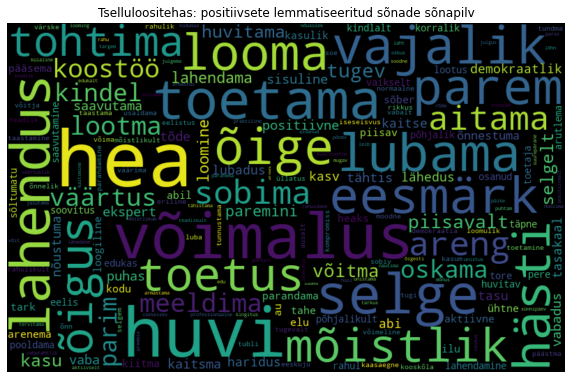

In [10]:
nimed_lemmad_words = ' '.join(map(str, list_pos))

wordcloud_nimed_lemmad = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimed_lemmad_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimed_lemmad, interpolation='bilinear')
plt.title(konflikt + ": positiivsete lemmatiseeritud sõnade sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis9_1_Pos_sonad_lemmatiseeritud_sonapilv.png")
plt.axis("off")
print("Positiivsed sõnad sõnapilves: ", len(list_pos))

Positiivsed sõnad sõnapilves:  5052


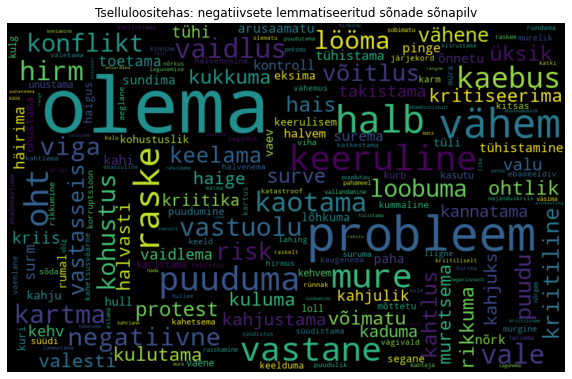

In [11]:
nimed_lemmad_words1 = ' '.join(map(str, list_neg))

wordcloud_nimed_lemmad1 = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimed_lemmad_words1)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimed_lemmad1, interpolation='bilinear')
plt.title(konflikt + ": negatiivsete lemmatiseeritud sõnade sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis9_2_Neg_sonad_lemmatiseeritud_sonapilv.png")
plt.axis("off")
print("Positiivsed sõnad sõnapilves: ", len(list_neg))

In [17]:
# Tulemused sorteeritud kordaja järgi, sõnu artiklis üle 50

tulemused_sort = tulemused[tulemused['sõnu uudises']>50].sort_values(by=['kordaja', 'positiivsus'], ascending=False)

In [18]:
tulemused_sort

,sõnu uudises,esimene isik,negatiivsus,kordaja,positiivsus,väljaanne,link,#
59,253,27,2,11.46,8,Delfi,https://www.delfi.ee/news/paevauudised/eesti/kristiina-ehin-presidendi-konest-kas-president-saadaks-oma-lapsed-ujuma-kohta-kust-kumme-kilomeetrit-ulesvoolu-on-tselluloositehas?id=81244107,60
212,619,32,18,8.08,21,ERR,https://www.err.ee/829639/foljeton-eesti2000-initsiatiivi-manifest,213
370,1028,40,42,7.98,25,ERR,https://www.err.ee/999292/mati-sepp-eesti-metsakasvatus-vajab-restarti,371
353,894,33,38,7.94,38,ERR,https://kultuur.err.ee/896944/taispikk-kone-edward-von-longus-surmatants,354
393,413,27,4,7.51,11,ERR,https://www.err.ee/1608283029/keskkonnaministeerium-vajaksime-puidu-vaarindamiseks-tselluloositehast,394
...,...,...,...,...,...,...,...,...
237,64,0,0,0.00,1,ERR,https://www.err.ee/835962/ratas-valitsus-arutab-eriplaneeringu-kusimust-lahiajal-kabinetinoupidamisel,238
3,97,0,0,0.00,0,Delfi,https://www.delfi.ee/news/paevauudised/eesti/kirju-karjaariga-ekssuusatajast-kaspar-kokkast-on-saanud-isamaa-suursponsor?id=90822727,4
31,61,0,0,0.00,0,Eesti Ekspress,https://ekspress.delfi.ee/teateid_elust/tulevane-tselluloositehas-naeb-investoritena-kogu-rahvast?id=82550051,32
214,94,0,0,0.00,0,ERR,https://www.err.ee/829836/otse-kell-13-riigikogu-infotunnis-ratas-anvelt-ja-kiisler,215


In [19]:
tulemused_sort.to_excel (r"tulemused_" + konflikt +"/" + konflikt + " tabel9_2_Meelsus_statistika_sorteeritud.xlsx", index = None, header=True)

In [20]:
#Kõrgeima kordajaga uudis
data['text'][59]

'Ehin ütles ERR-ile antud intervjuus, et presidendi kõne küll ühendas ja puudutas, nagu peabki, ent emana jäi tal saamata vastus ühele tähtsale küsimusele. "Kui me räägime looduskaitsest ja kui küsime küsimusi, millele me vastame, [et] "neil ei ole vastust", siis emana tahan küsida, kas me paneksime oma lasped ujuma kohta, kust kümme kilomeetrit ülesvoolu on siinkandi suurim tselluloositehas? Kas president saadaks oma lasped sinna ujuma? Need on Tartu ainsad ujumiskohad. Ma tahaksin vastust neile küsimustele," rääkis Ehin. Loodusvara puudutavad lõigud president Kaljulaidi kõnest: Meil koos teiste põhjala rahvastega on Euroopa kõige paremini säilinud looduskeskkond ja loodustunnetus. Milleks me oma loodusrikkust kasutame? Kas vahetame rahaks, nagu 20. sajandi tööstusühiskonnas tehti – või jätame lastelastele alles? Kas jätame lastelastele nii, nagu meid poleks siin olnudki, või tahame pigem, et meie heade otsuste muster oleks looduskeskkonnas 100 aasta pärast nähtav? Või lihtsalt loodam

In [22]:
# Skoor on 0
data['text'][252]

'Parlamendisaadikute küsimustele vastavad sel kolmapäeval riigikogu infotunnis peaminister Jüri Ratas, majandus- ja taristuminister Kadri Simson ning sotsiaalkaitseminister Kaia Iva. Kell 13 algavat infotundi saab otsepildis jälgida ERR.ee vahendusel. Ratas (Keskerakond) vastab küsimustele kavandatava tselluloositehase eriplaneeringu kohta, valitsemiskultuuri kohta ning võõrpäritolu üliõpilaste kohta Eesti ülikoolides. Majandus- ja taristuminister Kadri Simson (Keskerakond) vastab küsimustele ühistranspordi korraldamise, teekasutustasu ning Saaremaa sadamate kohta. Sotsiaalkaitseminister Kaia Iva (IRL) vastab küsimustele puudega inimeste abivahendite käibemaksu ning hoolduse korraldamise vastutuse kohta.'